# SEAROSE ICE INCURSION INCIDENT

In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
#from scipy.interpolate import RegularGridInterpolator as RGI

# CONSTANTS

In [2]:
from icedef.constants import *

# OCEAN DATA

In [3]:
ocean_file = '/home/evankielley/Data/Ocean/ECMWF/global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh_1534612034498.nc'
ocean_dataset = xr.open_dataset(ocean_file)
eastward_current_velocities = xr.DataArray(
    data=ocean_dataset.uo.values[:, 0, :, :],
    coords=[('time', ocean_dataset.time.values),
            ('latitude', ocean_dataset.latitude.values),
            ('longitude', ocean_dataset.longitude.values)],
    attrs=ocean_dataset.uo.attrs)
northward_current_velocities = xr.DataArray(
    data=ocean_dataset.vo.values[:, 0, :, :],
    coords=[('time', ocean_dataset.time.values),
            ('latitude', ocean_dataset.latitude.values),
            ('longitude', ocean_dataset.longitude.values)],
    attrs=ocean_dataset.vo.attrs)

# ATMOSPHERIC DATA

In [4]:
atm_files = ['/home/evankielley/Data/Atm/NARR/2017/20170328.nc',
                   '/home/evankielley/Data/Atm/NARR/2017/20170329.nc',
                   '/home/evankielley/Data/Atm/NARR/2017/20170330.nc']
atm_dataset = xr.open_mfdataset(atm_files)
atm_dataset['lon'] = np.mod(atm_dataset.lon - 180, 360) - 180
eastward_wind_velocities = xr.DataArray(
    data=atm_dataset.uwnd.values,
    coords=[('time', atm_dataset.time.values),
            ('latitude', atm_dataset.lat.values),
            ('longitude', atm_dataset.lon.values)],
    attrs=atm_dataset.uwnd.attrs)
northward_wind_velocities = xr.DataArray(
    data=atm_dataset.vwnd.values,
    coords=[('time', atm_dataset.time.values),
            ('latitude', atm_dataset.lat.values),
            ('longitude', atm_dataset.lon.values)],
    attrs=atm_dataset.vwnd.attrs)

# INTERPOLATION

In [5]:
def interpolate(point, data):
    def compute_interpolation(x0, xi, dx, data):
        indx = (xi - x0) / dx
        indx_floor = int(np.floor(indx))
        dindx = indx - indx_floor
        submatrix = data[indx_floor: indx_floor + 2, ...]
        data = (1 - dindx) * submatrix[0, ...] + dindx * submatrix[1, ...]
        return data

    assert data.dims == ('time', 'latitude', 'longitude')

    # time
    nptimes = data.time.values
    times = (nptimes - nptimes[0]) / np.timedelta64(1, 's')
    t0 = times[0]
    tn = times[-1]
    dt = np.mean(np.diff((times)))
    ti = (point[0] - nptimes[0]) / np.timedelta64(1, 's')
    assert t0 <= ti <= tn

    # latitude
    lats = data.latitude.values
    lat0 = lats[0]
    latn = lats[-1]
    dlat = np.mean(np.diff(lats))
    lati = point[1]
    assert lat0 <= lati <= latn

    # longitude
    lons = data.longitude.values
    lon0 = lons[0]
    lonn = lons[-1]
    dlon = np.mean(np.diff(lons))
    loni = point[2]
    assert lon0 <= loni <= lonn

    # crunch value
    data = data.values
    data = compute_interpolation(t0, ti, dt, data)
    data = compute_interpolation(lat0, lati, dlat, data)
    data = compute_interpolation(lon0, loni, dlon, data)

    return data

# SEAROSE

In [6]:
searose_latitude = 46.78851
searose_longitude = -48.01405

# ICEBERG

In [16]:
from icedef.iceberg import quickstart, dx_to_dlon, dy_to_dlat

In [17]:
# At 0145 on March 29, 2017, berg 011 was 4.2 NM away from SeaRose at a bearing of 346 deg T
iceberg_time = np.datetime64('2017-03-29T01:45')
iceberg_latitude = 46.85639904
iceberg_longitude = -48.03872578
iceberg = quickstart(iceberg_time, (iceberg_latitude, iceberg_longitude))

# DRIFT

In [18]:
from icedef import drift

In [19]:
from datetime import datetime

In [20]:
start_time = iceberg_time
start_datetime = datetime.utcfromtimestamp(start_time.astype(int) * 1e-9)
end_time = np.datetime64(iceberg_time + np.timedelta64(1, 'D'))
end_datetime = datetime.utcfromtimestamp(end_time.astype(int) * 1e-9)
start_latitude = iceberg_latitude
start_longitude = iceberg_longitude

dt_hours = 0.1
dt_seconds = dt_hours*3600
dt = np.timedelta64(int(dt_seconds), 's')
run_length = np.timedelta64(end_time - start_time, 's')
nt = run_length / dt

In [21]:
nt

240.0

In [22]:
iceberg = quickstart(start_time, (start_latitude, start_longitude))

iceberg_constants = {
    'sail_area': iceberg.geometry.sail_area,
    'keel_area': iceberg.geometry.keel_area,
    'top_area': iceberg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': iceberg.geometry.mass,
    'latitude': iceberg.latitude
}

point = (iceberg.time, iceberg.latitude, iceberg.longitude)

current_velocity = (interpolate(point, eastward_current_velocities),
                    interpolate(point, northward_current_velocities))

wind_velocity = (interpolate(point, eastward_wind_velocities),
                 interpolate(point, northward_wind_velocities))

for t in range(int(nt)):
    
    ax, ay = drift.newtonian_drift((iceberg.eastward_velocity, iceberg.northward_velocity), 
                             current_velocity, wind_velocity, 
                             iceberg_constants)
    
    iceberg.time += dt
    iceberg.eastward_velocity += ax * dt_seconds
    iceberg.northward_velocity += ay * dt_seconds
    iceberg.latitude += dy_to_dlat(iceberg.northward_velocity * dt_seconds)
    iceberg.longitude += dx_to_dlon(iceberg.eastward_velocity * dt_seconds, iceberg.latitude)
    
    point = (iceberg.time, iceberg.latitude, iceberg.longitude)
    
    current_velocity = (interpolate(point, eastward_current_velocities),
                       interpolate(point, northward_current_velocities))
    
    wind_velocity = (interpolate(point, eastward_wind_velocities),
                    interpolate(point, northward_wind_velocities))    
       
    iceberg_constants['latitude'] = iceberg.latitude
    iceberg.update_history()

# PLOT

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

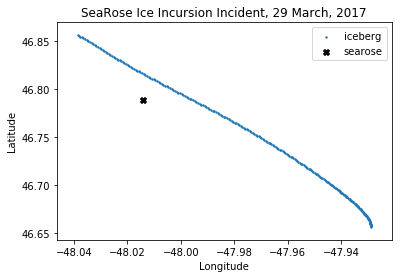

In [44]:
plt.scatter(iceberg.history['longitude'], iceberg.history['latitude'], 
            s=2, label='iceberg')
plt.scatter(searose_longitude, searose_latitude, marker='X', c='black', label='searose')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SeaRose Ice Incursion Incident, 29 March, 2017')
plt.show()